In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score
import re

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

from data_utils import DataUtils

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'content/mtsamples.csv'
MODEL_NAME = 'nlpie/distil-biobert'

In [4]:
df = pd.read_csv(DATASET_PATH, usecols=['medical_specialty', 'transcription'])
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [5]:
utils = DataUtils()
df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)
df['medical_specialty'] = df['medical_specialty'].str.strip()

===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...


===== Class Distribution =====
medical_specialty
General Medicine / SOAP / Chart / Progress Notes    425
Cardiovascular / Pulmonary                          371
Orthopedic                                          355
Neurology / Neurosurgery                            317
Gastroenterology                                    224
Urology                                             156
Obstetrics / Gynecology                             155
Discharge Summary                                   108
Name: count, dtype: int64


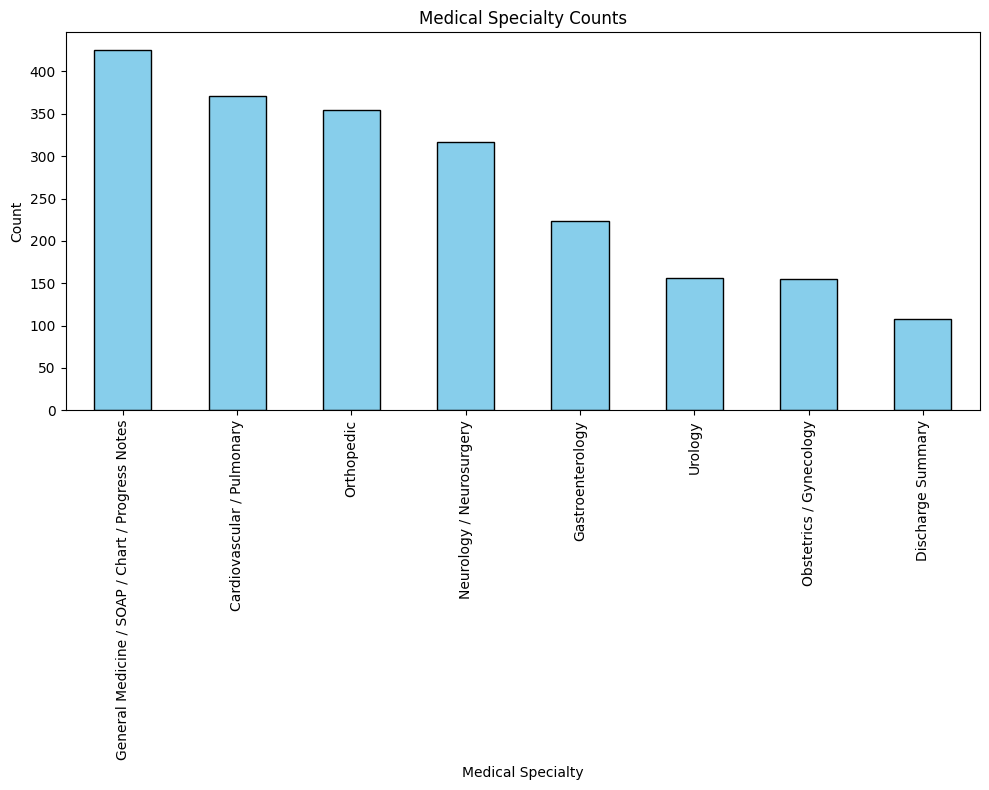

In [ ]:
excluded_specialities = [
    'Surgery', 'Consult - History and Phy.',  'Radiology'
] 
df = df[~df['medical_specialty'].isin(excluded_specialities)]

df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: 'Neurology / Neurosurgery' if x in ['Neurology', 'Neurosurgery'] else x
)

df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: 'General Medicine / SOAP / Chart / Progress Notes' if x in ['General Medicine', 'SOAP / Chart / Progress Notes'] else x
)

speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
df = df[df.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)

In [7]:
def preprocess_text(text):
    text = utils.clean_text(text)
    return text

df['text'] = df['transcription'].map(preprocess_text)

In [8]:
df['class_id'] = pd.factorize(df.medical_specialty)[0]

print(f"Shape: {df.shape}")
print(f"Number of unique classes: {df.class_id.unique()}")

df.head()

Shape: (2111, 4)
Number of unique classes: [0 1 2 3 4 5 6 7]


,medical_specialty,transcription,text,class_id
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",d m mode . left atrial enlargement with left a...,0
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,. the left ventricular cavity size and wall th...,0
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",d echocardiogram multiple views of the heart a...,0
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",description . normal cardiac chambers size. . ...,0
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",d study . mild aortic stenosis widely calcifie...,0


In [9]:
ros = RandomOverSampler(random_state=42)
df_resampled, y_resampled = ros.fit_resample(
    df[['text']],
    df['class_id']
)

df_resampled['label'] = y_resampled
print(f"Resampled Shape: {df_resampled.shape}")

Resampled Shape: (3400, 2)


In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokens = tokenizer(
    df_resampled['text'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=MAX_SEQ_LEN,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df_resampled["label"].values)

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

dataset = CustomDataset(input_ids, attention_mask, labels)
train_size = int((1 - DS_SPLIT) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [12]:
codes, uniques = pd.factorize(df["medical_specialty"])

label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/distil-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [14]:
training_args = TrainingArguments(
    output_dir="./results",         
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,             
    weight_decay=0.01,
    report_to="none",
    logging_dir=None,           
    logging_steps=-1
)

trainer = Trainer(
    model=model,       
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.819934070110321, 'eval_accuracy': 0.7352941176470589, 'eval_f1_weighted': 0.7245771823561332, 'eval_runtime': 2.6114, 'eval_samples_per_second': 260.399, 'eval_steps_per_second': 16.466, 'epoch': 1.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.560820460319519, 'eval_accuracy': 0.8235294117647058, 'eval_f1_weighted': 0.8204530583302199, 'eval_runtime': 2.6127, 'eval_samples_per_second': 260.272, 'eval_steps_per_second': 16.458, 'epoch': 2.0}
{'loss': 0.8994, 'grad_norm': 8.342325210571289, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.519769549369812, 'eval_accuracy': 0.8382352941176471, 'eval_f1_weighted': 0.8357738642168435, 'eval_runtime': 2.5972, 'eval_samples_per_second': 261.818, 'eval_steps_per_second': 16.556, 'epoch': 3.0}
{'train_runtime': 108.3527, 'train_samples_per_second': 75.31, 'train_steps_per_second': 4.707, 'train_loss': 0.8993839637905944, 'epoch': 3.0}


TrainOutput(global_step=510, training_loss=0.8993839637905944, metrics={'train_runtime': 108.3527, 'train_samples_per_second': 75.31, 'train_steps_per_second': 4.707, 'total_flos': 540524817285120.0, 'train_loss': 0.8993839637905944, 'epoch': 3.0})

  0%|          | 0/43 [00:00<?, ?it/s]

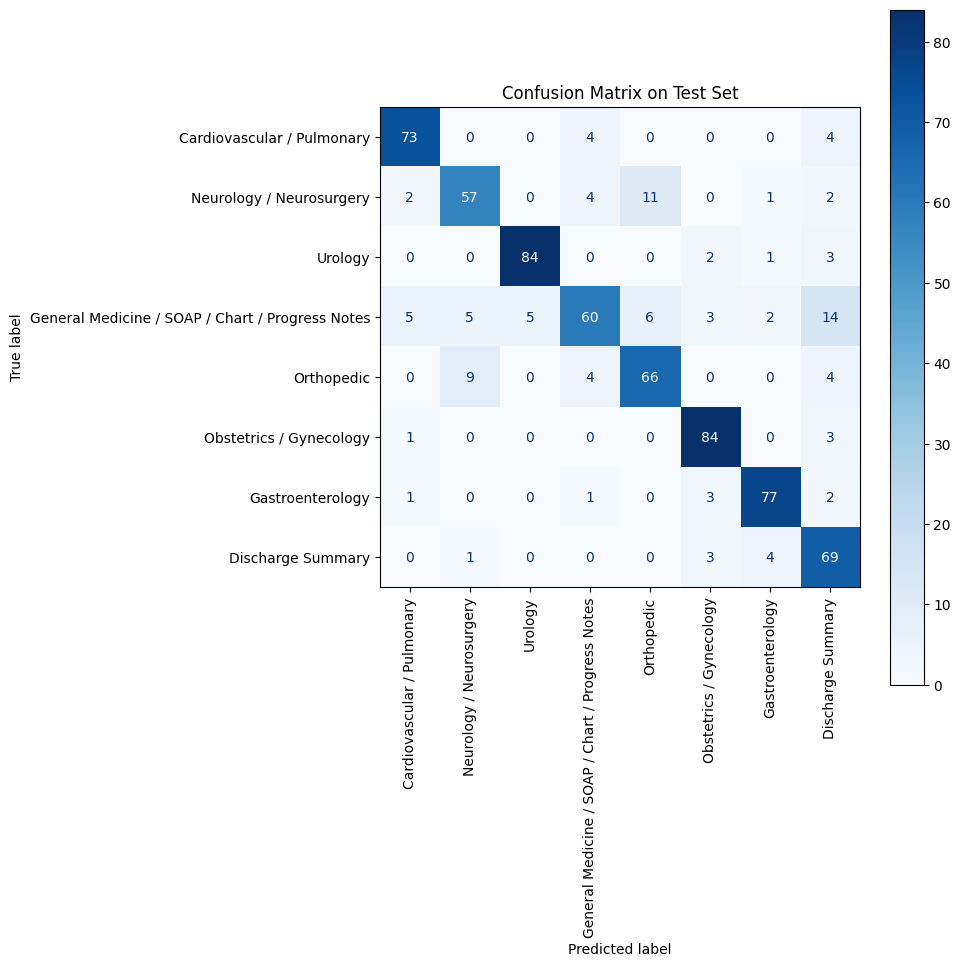

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_output = trainer.predict(test_dataset)
logits = pred_output.predictions
y_pred = np.argmax(logits, axis=1)
y_true = pred_output.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=uniques)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()